In [2]:
import argparse
import os
import sys
import time
import math
import numpy as np
import torch
import torch.nn.functional as F
import scipy.sparse as sp
import h5py
import random
from copy import copy
from datetime import datetime
import argparse
from IPython import embed
from generate_burgers import burgers_numeric_solve
import pdb
import torch
import torch.nn as nn
import matplotlib.pylab as plt
import tqdm
import termcolor
from torch.utils.data import Dataset, DataLoader

parser = argparse.ArgumentParser(description='Generating PDE data')
parser.add_argument('--experiment', type=str, default='burgers_pid',
                    help='Experiment for which data should create for')
parser.add_argument('--exp_path', default='/user/project/pde_gen_control', type=str, help='experiment folder')
parser.add_argument('--date_time', default='2023-12-01_test', type=str, help='experiment date')
parser.add_argument('--model_type', default='PID', type=str, help='model type.')
parser.add_argument('--gpuid', type=int, default=0,
                    help='Used device id')
parser.add_argument('--num_f', default=500, type=int,
                    help='the number of force data')
parser.add_argument('--num_u0', default=60, type=int, 
                    help='the number of initial data')
parser.add_argument('--train_samples', type=int, default=24000,
                    help='Samples in the training dataset')
# parser.add_argument('--valid_samples', type=int, default=0,
#                     help='Samples in the validation dataset')
parser.add_argument('--test_samples', type=int, default=6000,
                    help='Samples in the test dataset')
parser.add_argument('--log', type=eval, default=False,
                    help='pip the output to log file')
parser.add_argument('--max_iter_steps', type=int, default=10,
                    help='max iter steps for tuning params of PID')
parser.add_argument('--max_training_iters', type=int, default=10,
                    help='max number of iters for tuning params of PID')
parser.add_argument('--save_iters', type=int, default=5,
                    help='save weight each save_iters iters')
parser.add_argument('--model_mode', type=str, default='train',
                    help='train or eval')
parser.add_argument('--model_weight_path', type=str, default='train',
                    help='path of model weight')
parser.add_argument('--dataset_path', type=str, default='/user/project/pde_gen_control/dataset/dataset_control_burgers/free_u_f_1e5',
                    help='path of dataset path')
parser.add_argument('--train_batch_size', type=int, default=100,
                    help='batch size for training')
parser.add_argument('--lr', type=float, default=1e-4,
                    help='batch size for training')
parser.add_argument('--coef_f_loss', type=float, default=0,
                    help='coef_f_loss')
parser.add_argument('--is_partially_controllable', type=int, default=0,
                    help='0: fully controllable; 1. partially_controllable')
parser.add_argument('--simulation_method', type=str, default="solver",
                    help='solver or surrogate_model')
parser.add_argument('--pde_1d_surrogate_model_checkpoint', type=str, default="/user/project/pde_gen_control/checkpoints/pde_1d/full_ob_full_ctr_3-step",
                    help='1d pde surrogate_model checkpoint path')
parser.add_argument('--f_max', type=float, default=1.0,
                    help='1d pde surrogate_model checkpoint path')
parser.add_argument('--is_partially_observable', type=int, default=0,
                    help='0: fully observable; 1. partially_observable')

args=parser.parse_args([])

In [4]:
args.gpuid = 5
args.dataset_path="YOUR_DATA_PATH"
args.pde_1d_surrogate_model_checkpoint="YOUR_MODEL_PATH"
args.is_partially_observable=0
milestone=500
if args.is_partially_observable==1:
    s_ob=64
else:
    s_ob=128

from multiprocessing import cpu_count
from torch.utils.data import Dataset, DataLoader
def cycle(dl):
    while True:
        for data in dl:
            yield data
device=f"cuda:{args.gpuid}"
from data_burgers_1d import Burgers1DSimple, Burgers
# RESCALER=6.4519
test_dataset= Burgers1DSimple(
    dataset="burgers",
    input_steps=1,
    output_steps=10,
    time_interval=1,
    is_y_diff=False,
    split="test",
    transform=None,
    pre_transform=None,
    verbose=False,
    root_path =args.dataset_path ,
    device='cuda',
    rescaler=1
    )
from model.pde_1d_surrogate_model.burgers_operator import Simu_surrogate_model
simu_surrogate_model=Simu_surrogate_model(path=args.pde_1d_surrogate_model_checkpoint,device=device,s_ob=s_ob,milestone=milestone)

Load dataset /user/project/pde_gen_control/dataset/dataset_control_burgers/free_u_f_1e5/burgers_test.h5


In [5]:
dl=DataLoader(test_dataset, batch_size = args.train_batch_size, shuffle = False, pin_memory = True, num_workers =24)
dl=cycle(dl)
data = next(dl).to(device)
u0=data[:,0].clone()
ud=data[:,10].clone()
ut_gd=data[:,1:11]
control_list=data[:,11:].clone()
print(control_list.shape)
u_target=data[:,[10]].clone()
u_0_to_T=torch.zeros_like(data[:,:10])
u_0_to_T[:,0]=u0
u_0_to_T_single=torch.zeros_like(data[:,:10])
u_0_to_T_single[:,0]=u0
if args.is_partially_observable==1:
    u0=torch.cat([u0[:,:32],u0[:,-32:]],dim=1)
    ut_gd=torch.cat([ut_gd[:,:,:32],ut_gd[:,:,-32:]],dim=2)
    u_0_to_T=torch.cat([u_0_to_T[:,:,:32],u_0_to_T[:,:,-32:]],dim=2)
    u_0_to_T_single=torch.cat([u_0_to_T_single[:,:,:32],u_0_to_T_single[:,:,-32:]],dim=2)
print(u_0_to_T.shape)
for i in range(10):
    #########################
    ft=control_list[:,[i]] #ft [batch_size,1,ns=128]
    ########################
    if i==0:
        u_0_to_T[:,[i]]=simu_surrogate_model.simulation(ut=u0,ft=ft)
        u_0_to_T_single[:,[i]]=u_0_to_T[:,[i]].clone()
    else:
        u_0_to_T_single[:,[i]]=simu_surrogate_model.simulation(ut=ut_gd[:,i-1].clone(),ft=control_list[:,[i]]) 
        u_0_to_T[:,[i]]=simu_surrogate_model.simulation(ut=u_0_to_T[:,[i-1]].clone(),ft=ft)  #ut [batch_size,1,ns] ,u_{t+1} [batch_size,1,ns]  

#following caculated relative MSE between u_0_to_T and ut_gd
mae=torch.nn.L1Loss()


#following caculate MSE of u_0_to_T and data[:,1:11]
mse=torch.nn.MSELoss()
loss=mae(u_0_to_T_single[:,:],ut_gd)
print("MAE: ",loss)

#following caculate MSE of u_0_to_T and data[:,1:11]
mse=torch.nn.MSELoss()
loss=mae(u_0_to_T[:,:],ut_gd)
print("MAE(autoregress): ",loss)

#following caculate MSE of u_0_to_T and data[:,1:11]
mse=torch.nn.MSELoss()
loss=mse(u_0_to_T_single[:,:],ut_gd)
# loss=(u_0_to_T_single-ut_gd).square().mean()
print("MSE: ",loss)

#following caculate MSE of u_0_to_T and data[:,1:11]
mse=torch.nn.MSELoss()
loss=mse(u_0_to_T[:,:],ut_gd)
print("MSE(autoregress): ",loss)

torch.Size([100, 10, 128])
torch.Size([100, 10, 128])
MAE:  tensor(0.0007, device='cuda:5')
MAE(autoregress):  tensor(0.0012, device='cuda:5')
MSE:  tensor(2.5138e-06, device='cuda:5')
MSE(autoregress):  tensor(6.7285e-06, device='cuda:5')


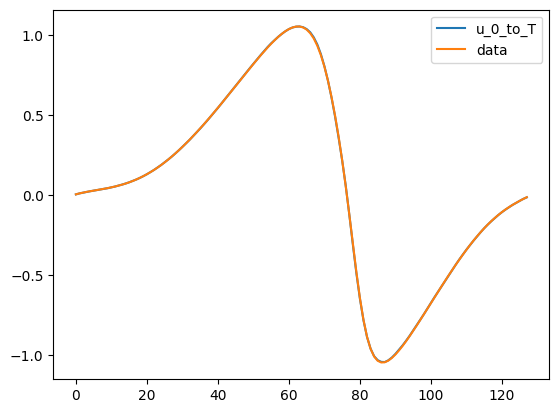

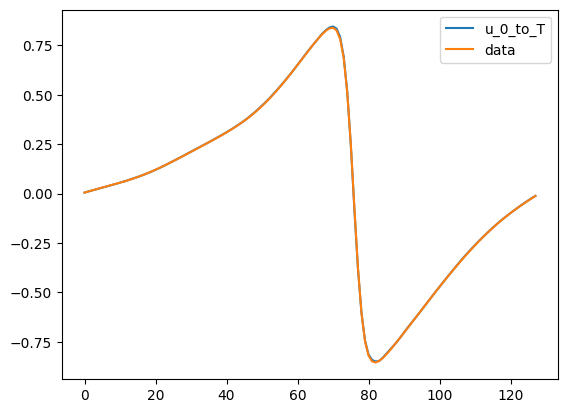

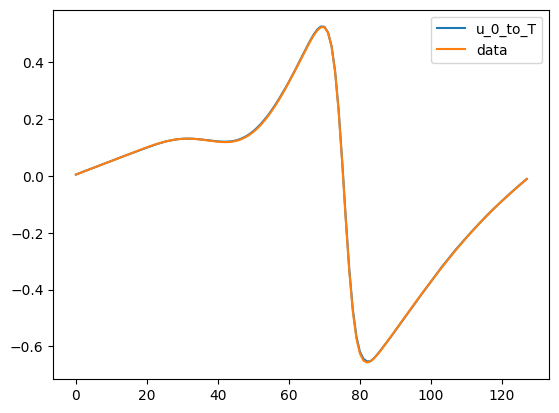

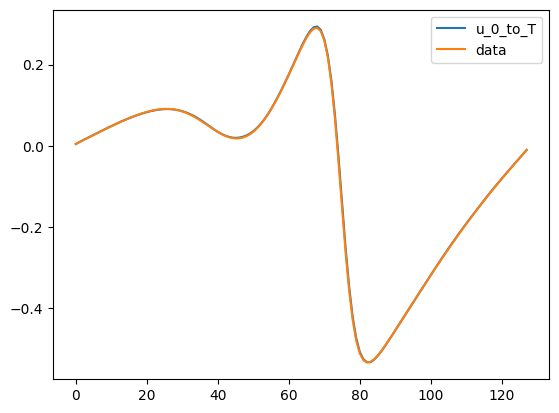

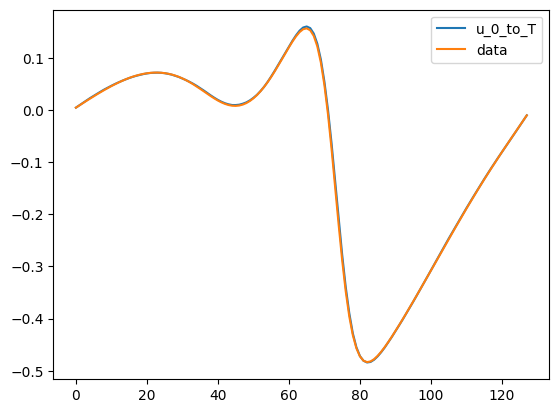

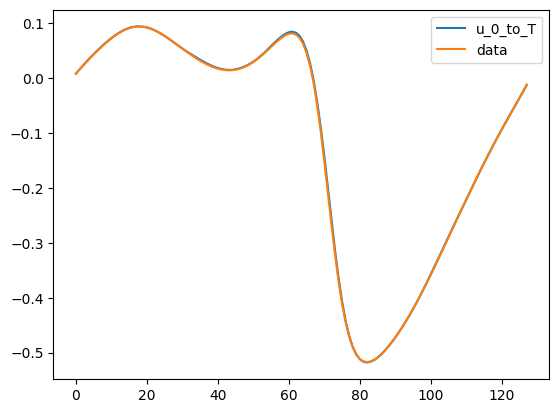

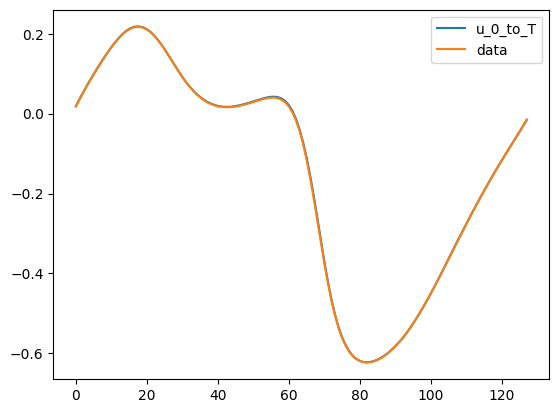

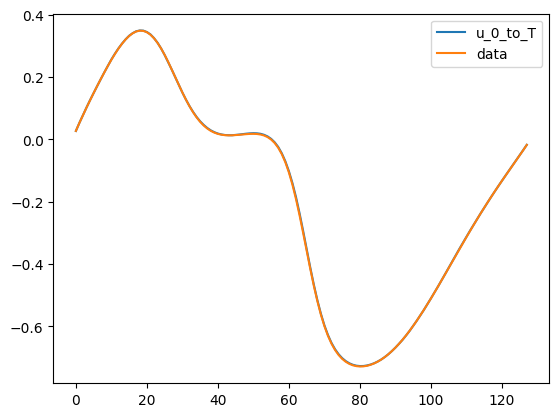

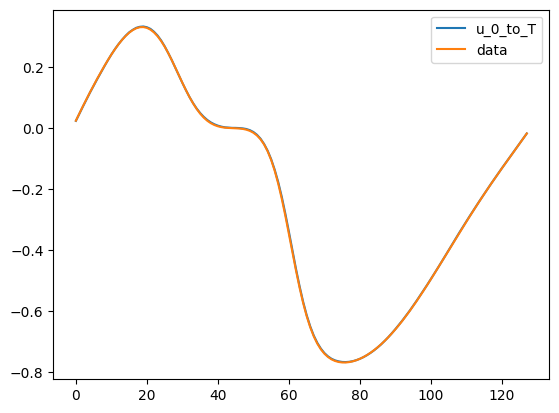

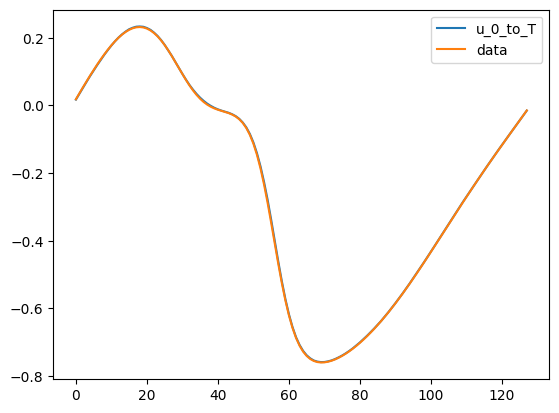

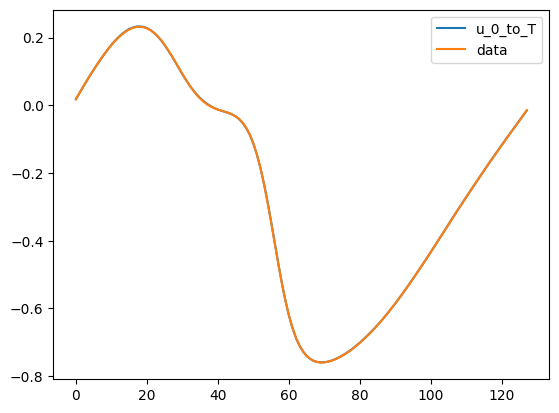

In [6]:
# print(u_0_to_T[0,:])
# print(data[0,1:11])
#following draw u_0_to_T and data[:,1:11]

#folowing 
plt.figure()
plt.plot(u_0_to_T[4,0].cpu().numpy(),label="u_0_to_T")
plt.plot(ut_gd[4,0].cpu().numpy(),label="data")
plt.legend()

plt.figure()
plt.plot(u_0_to_T[4,1].cpu().numpy(),label="u_0_to_T")
plt.plot(ut_gd[4,1].cpu().numpy(),label="data")
plt.legend()

plt.figure()
plt.plot(u_0_to_T[4,2].cpu().numpy(),label="u_0_to_T")
plt.plot(ut_gd[4,2].cpu().numpy(),label="data")
plt.legend()

plt.figure()
plt.plot(u_0_to_T[4,3].cpu().numpy(),label="u_0_to_T")
plt.plot(ut_gd[4,3].cpu().numpy(),label="data")
plt.legend()

plt.figure()
plt.plot(u_0_to_T[4,4].cpu().numpy(),label="u_0_to_T")
plt.plot(ut_gd[4,4].cpu().numpy(),label="data")
plt.legend()

plt.figure()
plt.plot(u_0_to_T[4,5].cpu().numpy(),label="u_0_to_T")
plt.plot(ut_gd[4,5].cpu().numpy(),label="data")
plt.legend()

plt.figure()
plt.plot(u_0_to_T[4,6].cpu().numpy(),label="u_0_to_T")
plt.plot(ut_gd[4,6].cpu().numpy(),label="data")
plt.legend()

plt.figure()
plt.plot(u_0_to_T[4,7].cpu().numpy(),label="u_0_to_T")
plt.plot(ut_gd[4,7].cpu().numpy(),label="data")
plt.legend()

plt.figure()
plt.plot(u_0_to_T[4,8].cpu().numpy(),label="u_0_to_T")
plt.plot(ut_gd[4,8].cpu().numpy(),label="data")
plt.legend()

plt.figure()
plt.plot(u_0_to_T[4,9].cpu().numpy(),label="u_0_to_T")
plt.plot(ut_gd[4,9].cpu().numpy(),label="data")
plt.legend()

plt.figure()
plt.plot(u_0_to_T_single[4,9].cpu().numpy(),label="u_0_to_T")
plt.plot(ut_gd[4,9].cpu().numpy(),label="data")
plt.legend()